In [1]:
from __future__ import (absolute_import, division,print_function, unicode_literals)
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Загрузим данные предобработанной тренировочной выборки

In [2]:
#len(data_cat) 
path='C:\\Users\\Pavel_2\\HSE\\Beeline\\'
is_outlier=(np.loadtxt(path+'is_outlier.csv')).astype(bool)

# поскольку при сохранении в файл задавался параметр index=False, то для корректного слияния таблиц 
# их нужно привести к одинаковой размерности заранее до pd.concat, иначе при некорректном слиянии будут nan
data_cat= pd.read_csv(path+'data_cat.csv')[~is_outlier].reset_index(drop=True)
data_cat_LE= pd.read_csv(path+'data_cat_LE.csv')[~is_outlier].reset_index(drop=True)
data_cat_conj= pd.read_csv(path+'data_cat_conj.csv')[~is_outlier].reset_index(drop=True)
data_means_map= pd.read_csv(path+'data_means_map.csv') #49500
deanonimiz_data=pd.read_csv(path+'deanonimiz_data.csv')[~is_outlier].reset_index(drop=True)

data_train_XGB= pd.read_csv(path+'data_train_XGB.csv')[~is_outlier].reset_index(drop=True)
features_train_XGB=pd.read_csv(path+'features_train_XGB.csv')[~is_outlier].reset_index(drop=True)

new_data_real= pd.read_csv(path+'new_data_real.csv') # 49500
data_real_ln= pd.read_csv(path+'data_real_ln.csv')# 49500
data_real_53_61= pd.read_csv(path+'data_real_53_61.csv')# 49500

data_discrete= pd.read_csv(path+'data_discrete.csv')[~is_outlier].reset_index(drop=True)

In [3]:
y_train = pd.read_csv(path+'train.csv')['y'][~is_outlier].reset_index(drop=True)

###  Часть 7. Отбор признаков

Посчитаем общее количество старых и полученных новых признаков.

In [4]:
feature_selection_data=[data_cat, data_cat_LE, data_cat_conj, deanonimiz_data, data_means_map, features_train_XGB,\
                       new_data_real, data_real_ln, data_real_53_61, data_discrete]
feature_count=[]
for data_ in feature_selection_data:
    feature_count.append(data_.shape[1])
    
del feature_selection_data #очистим память 
print (feature_count, sum(feature_count))

[200, 19, 171, 3, 160, 23, 41, 11, 19, 2] 649


In [5]:
# http://datareview.info/article/otbor-priznakov-dlya-mashinnogo-obucheniya-na-python/

Первоначально отберем признаки используя обученную модель из которой будем брать feature importances. Чтобы не мешать отбор признаков разобьем отбор признаков на основе важности на несколько этапов:

1. отбор категориальных признаков
2. отбор числовых признаков
3. окончательный отбор признаков

 Для категориальных признаков рассмотрим 3 метода отбора признаков на Python

**Отбор на основе важности признаков**

Ансамблевые алгоритмы на основе деревьев решений, такие как случайный лес (random forest), позволяют оценить важность признаков. В представленном ниже примере мы обучаем классификатор RandomForestClassifier, чтобы с его помощью определить важность признаков

In [6]:
#from sklearn.ensemble import ExtraTreesClassifier
#model = ExtraTreesClassifier(verbose=1)
from sklearn.ensemble.forest import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000,max_features=25,random_state=17,verbose=1)

In [7]:
data_feature_selection=pd.concat([data_cat,data_cat_LE,data_cat_conj,data_means_map,deanonimiz_data], axis=1)
model.fit(data_feature_selection, y_train)
importances = model.feature_importances_

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  7.6min finished


553
x30_RF_by_['x10']_mean    0.011777
x8_RF_by_['x21']_mean     0.011486
x8_RF_by_['x10']_mean     0.011440
x56_RF_by_['x10']_mean    0.010833
x56_RF_by_['x21']_mean    0.009934
x8_RF_by_['x18']_mean     0.009496
x32_RF_by_['x10']_mean    0.009433
x43_RF_by_['x10']_mean    0.009247
x44_RF_by_['x10']_mean    0.009185
x23_RF_by_['x10']_mean    0.009094
Name: RandomForest, dtype: float64


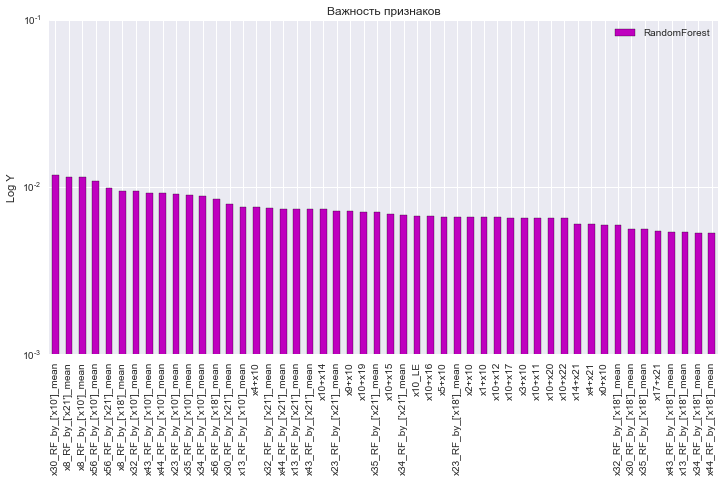

In [8]:
features_cat_df =pd.DataFrame(data=importances, index=list(data_feature_selection.columns), columns=['RandomForest'])
features_cat_df.sort_values(by='RandomForest', ascending=False, inplace=True)
print (features_cat_df.shape[0])
print (features_cat_df['RandomForest'][:10])
features_cat_df[:50].plot(kind='bar',figsize=(12,6),color='m',logy=True) #sort_columns=True
plt.ylabel("Log Y")
plt.title(u"Важность признаков");

In [9]:
features_cat_df[:10]

,RandomForest
x30_RF_by_['x10']_mean,0.011777
x8_RF_by_['x21']_mean,0.011486
x8_RF_by_['x10']_mean,0.011440
x56_RF_by_['x10']_mean,0.010833
x56_RF_by_['x21']_mean,0.009934
x8_RF_by_['x18']_mean,0.009496
x32_RF_by_['x10']_mean,0.009433
x43_RF_by_['x10']_mean,0.009247
x44_RF_by_['x10']_mean,0.009185
x23_RF_by_['x10']_mean,0.009094


**Одномерный отбор признаков**

Признаки, имеющие наиболее выраженную взаимосвязь с целевой переменной, могут быть отобраны с помощью статистических критериев. Библиотека scikit-learn содержит класс SelectKBest, реализующий одномерный отбор признаков (univariate feature selection). Этот класс можно применять совместно с различными статистическими критериями для отбора заданного количества признаков. Будем отбирать  100 признаков.

In [10]:
# Chi-squared stats of non-negative features for classification tasks
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(data_feature_selection)

In [11]:
%%time
from sklearn.feature_selection import SelectKBest, chi2 

# feature extraction
model = SelectKBest(score_func=chi2, k=100)
fit = model.fit(X, y_train)
#numpy.set_printoptions(precision=3)# три знака при использовании print после запятой

# summarize scores
features_cat_df2 =pd.DataFrame(data=fit.scores_, \
                              index=list(data_feature_selection.columns), columns=['SelectKBest'])
features_cat_df2.sort_values(by='SelectKBest',ascending=False, inplace=True)

Wall time: 5.31 s


In [12]:
features_cat_df2[:10]

,SelectKBest
x11_669ea3d319,2486.022524
x12_b38690945d,2382.082778
x11_91bb549494,1968.435230
x12_e33c63cf35,1955.735996
x30_RF_by_['x11']_mean,1897.055020
x8_RF_by_['x11']_mean,1528.139810
x30_RF_by_['x10']_mean,1304.854611
x56_RF_by_['x11']_mean,1242.008925
x56_RF_by_['x12']_mean,1237.642985
x30_RF_by_['x12']_mean,1214.424847


**Рекурсивное исключение признаков**

Метод рекурсивного исключения признаков (recursive feature elimination, RFE) реализует следующий алгоритм: модель обучается на исходном наборе признаков и оценивает их значимость, затем исключается один или несколько наименее значимых признаков, модель обучается на оставшихся признаках, и так далее, пока не останется заданное количество лучших признаков.

In [13]:
%%time
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
              
model = LogisticRegression()
rfe = RFE(model,100,step=10, verbose=1)
fit = rfe.fit(X, y_train) 

Fitting estimator with 553 features.
Fitting estimator with 543 features.
Fitting estimator with 533 features.
Fitting estimator with 523 features.
Fitting estimator with 513 features.
Fitting estimator with 503 features.
Fitting estimator with 493 features.
Fitting estimator with 483 features.
Fitting estimator with 473 features.
Fitting estimator with 463 features.
Fitting estimator with 453 features.
Fitting estimator with 443 features.
Fitting estimator with 433 features.
Fitting estimator with 423 features.
Fitting estimator with 413 features.
Fitting estimator with 403 features.
Fitting estimator with 393 features.
Fitting estimator with 383 features.
Fitting estimator with 373 features.
Fitting estimator with 363 features.
Fitting estimator with 353 features.
Fitting estimator with 343 features.
Fitting estimator with 333 features.
Fitting estimator with 323 features.
Fitting estimator with 313 features.
Fitting estimator with 303 features.
Fitting estimator with 293 features.
F

In [14]:
features_cat_df3 =pd.DataFrame(data=fit.ranking_, \
                              index=list(data_feature_selection.columns), columns=['RFE'])
# ascending=True -  Отобранные признаки помечены значением  значением «1» в массиве ranking_.   
features_cat_df3.sort_values(by='RFE',ascending=True, inplace=True)
features_cat_df3[:10]

,RFE
x13_RF_by_['x0']_mean,1
x10_47bdeb833e,1
x15+x21,1
x13_RF_by_['x5']_mean,1
x56_RF_by_['x18']_mean,1
x13_RF_by_['x17']_mean,1
x10_1d42d0c490,1
x15+x20,1
x56_RF_by_['x17']_mean,1
x8_RF_by_['x4']_mean,1


Мы отбирали по 100 признаков каждым методом, теперь объединим все три списка лучших признаков отобранных каждым методом

In [6]:
import pickle
with open (path+'features_cat.csv','rb') as fp:
    features_cat=pickle.load(fp)

In [ ]:
features_cat=list(features_cat_df.index.values[:100])+list(features_cat_df2.index.values[:100]) \
             +list(features_cat_df3.index.values[:100])
features_cat=set(features_cat)

In [7]:
len(features_cat)

238

In [17]:
import pickle
with open (path+'features_cat.csv','wb') as fp:
    pickle.dump(features_cat,fp)

**отбор числовых признаков**

In [19]:
#del model
from sklearn.ensemble.forest import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000,max_features=25,random_state=17,verbose=1)

In [21]:
data_feature_selection=pd.concat([features_train_XGB, new_data_real, data_real_ln, data_real_53_61, data_discrete], \
                                 axis=1)# data_train_XGB только для подачи в XGBoost
model.fit(data_feature_selection, y_train)
importances = model.feature_importances_

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 13.0min finished


96
x8_XGB     0.198407
x8_RF      0.145963
x30_RF     0.064912
x29_RF     0.029831
x30_XGB    0.027372
x13_RF     0.014990
x32_RF     0.013896
x56_XGB    0.013112
x56_RF     0.012407
x23_ln     0.011472
Name: importances, dtype: float64


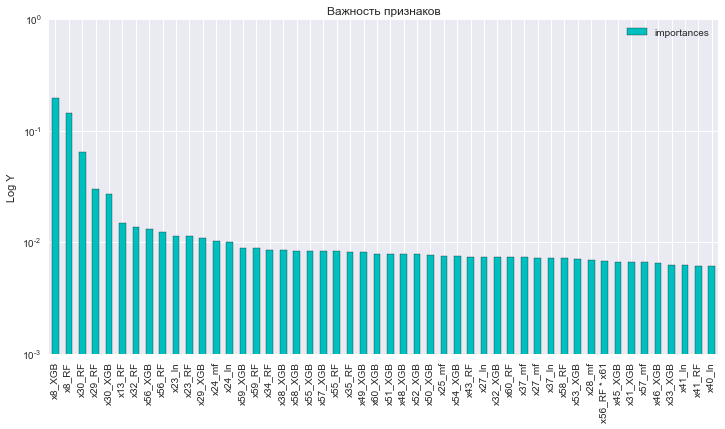

In [22]:
features_real_df =pd.DataFrame(data=importances, index=list(data_feature_selection.columns), columns=['importances'])
features_real_df.sort_values(by='importances', ascending=False, inplace=True)
print (features_real_df.shape[0])
print (features_real_df['importances'][:10])
features_real_df[:50].plot(kind='bar',figsize=(12,6),color='c',logy=True) #sort_columns=True
plt.ylabel("Log Y")
plt.title(u"Важность признаков");

Числовые признаки имели ряд пропусков в данных  и было сделано ряд предобработок для заполнения пропусков. После ранжирования признаков следует удалить взаимно дублирующие друг друга признаки

In [23]:
data_feature_importances_=pd.DataFrame()
features=[features_train_XGB, new_data_real, data_real_ln]

for feature in features:    
    data_feature_importances=features_real_df.loc[features_real_df.index.isin(feature)].sort_index()
    data_feature_importances.index=[x.split('_')[0] for x in data_feature_importances.index ] 
    data_feature_importances_=pd.concat([data_feature_importances_,data_feature_importances],axis=1)
    
data_feature_importances_.reset_index(inplace=True) 
data_feature_importances_=pd.concat([data_feature_importances_, pd.DataFrame(new_data_real.columns)],axis=1)
data_feature_importances_.columns=['feature','XGB','RF/md/mf','Log','name for RF/md/mf']    
data_feature_importances_[:20]

,feature,XGB,RF/md/mf,Log,name for RF/md/mf
0,x13,NaN,0.014990,NaN,x13_RF
1,x23,NaN,0.011434,0.011472,x23_RF
2,x24,NaN,0.010299,0.010064,x24_mf
3,x25,NaN,0.007546,NaN,x25_mf
4,x26,NaN,0.005219,0.005220,x26_md
5,x27,NaN,0.007291,0.007445,x27_mf
6,x28,NaN,0.006900,NaN,x28_mf
7,x29,0.011072,0.029831,NaN,x29_RF
8,x30,0.027372,0.064912,NaN,x30_RF
9,x31,0.006701,0.005173,NaN,x31_RF


In [24]:
def f(x):
    _max=0
    if x['XGB']<> np.nan and x['XGB']>x['RF/md/mf'] : 
        _max=x['feature']+'_XGB'
    elif x['Log']>x['RF/md/mf'] and x['Log']>_max:
        _max=x['feature']+'_ln'
    else: _max=x['name for RF/md/mf']  
    return _max

In [25]:
new_real_features=list(data_feature_importances_.apply(f, axis=1).values)

In [26]:
new_real_features

['x13_RF',
 u'x23_ln',
 'x24_mf',
 'x25_mf',
 u'x26_ln',
 u'x27_ln',
 'x28_mf',
 'x29_RF',
 'x30_RF',
 u'x31_XGB',
 'x32_RF',
 u'x33_XGB',
 'x34_RF',
 'x35_RF',
 'x36_mf',
 'x37_mf',
 u'x38_XGB',
 u'x39_ln',
 u'x40_ln',
 u'x41_ln',
 u'x42_ln',
 'x43_RF',
 'x44_RF',
 u'x45_XGB',
 u'x46_XGB',
 u'x47_XGB',
 u'x48_XGB',
 u'x49_XGB',
 u'x50_XGB',
 u'x51_XGB',
 u'x52_XGB',
 u'x53_XGB',
 u'x54_XGB',
 u'x55_XGB',
 u'x56_XGB',
 u'x57_XGB',
 u'x58_XGB',
 u'x59_XGB',
 u'x60_XGB',
 'x61_md',
 u'x8_XGB']

In [27]:
len(new_real_features)

41

In [28]:
with open (path+'new_real_features.csv','wb') as fp:
    pickle.dump(new_real_features,fp)

In [8]:
import pickle
with open (path+'new_real_features.csv','rb') as fp:
    new_real_features=pickle.load(fp)

Рассмотрим корреляцию числовых признаков с целевой переменной

x8_XGB     0.593535
x30_RF     0.338121
x56_XGB    0.217315
x34_RF     0.215457
x35_RF     0.209959
x13_RF     0.198769
x23_ln     0.174799
x32_RF     0.156383
x43_RF     0.155211
x44_RF     0.150951
dtype: float64


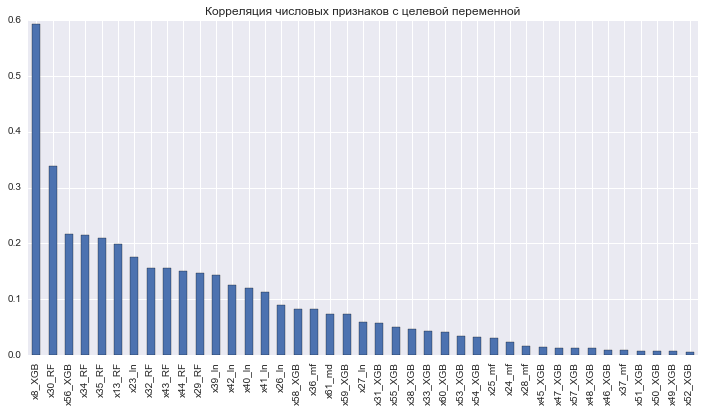

In [31]:
corr_df= np.abs(data_feature_selection[new_real_features].corrwith(y_train, axis=0, drop=False))\
                .sort_values(ascending=False)
print (corr_df[:10])
corr_df.plot(kind='bar',figsize=(12,6));
plt.title(u"Корреляция числовых признаков с целевой переменной");

**окончательный отбор признаков**

In [9]:
features_final=list(features_cat)+new_real_features
len(features_final)

279

### Часть 8. Построение модели

Поскольку мы отобрали признаки для построения модели сформируем датесеты для обучения и тестирования моделей

In [10]:
X_train=pd.concat([data_cat,data_cat_LE,data_cat_conj,data_means_map,deanonimiz_data, \
                      features_train_XGB, new_data_real, data_real_ln, data_real_53_61, data_discrete], axis=1) \
                      [features_final]  

In [11]:
del data_cat,data_cat_LE,data_cat_conj,data_means_map,deanonimiz_data, \
    features_train_XGB, new_data_real, data_real_ln, data_real_53_61, data_discrete

In [12]:
%%time
from sklearn.ensemble.forest import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,max_features=25,random_state=7,verbose=1)
model.fit(X_train, y_train)
importances = model.feature_importances_

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


279
x8_XGB     0.195240
x57_XGB    0.031667
x56_XGB    0.026425
x58_XGB    0.022755
x38_XGB    0.017767
x59_XGB    0.014082
x30_RF     0.013372
x29_RF     0.009977
x60_XGB    0.009711
x55_XGB    0.009120
Name: importances, dtype: float64


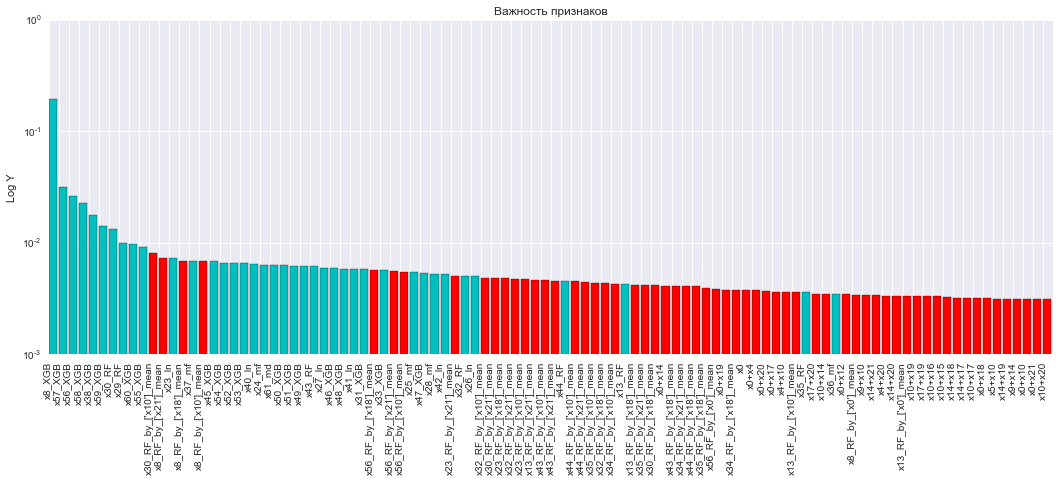

In [13]:
features_full=pd.DataFrame(data=importances, index=list(X_train.columns), columns=['importances'])
features_full.sort_values(by='importances', ascending=False, inplace=True)
print (features_full.shape[0])
print (features_full['importances'][:10])

plt.figure(figsize=(18,6))
n=100
i=0
for f in features_full[:n].index:
    color='r'
    if f in new_real_features:
        color='c'
    plt.bar(i,features_full.ix[f],color=color)
    i+=1

labels=features_full[:n].reset_index()['index'].tolist()    
xticks_pos=[i for i in range(len(features_full[:n]))]    
plt.xticks(xticks_pos,labels,rotation=90) 

plt.yscale('log')
plt.ylabel("Log Y")
plt.title(u"Важность признаков");

сформируем датасеты тестирования моделей

In [14]:
data_test_cat= pd.read_csv(path+'data_test_cat.csv')
data_test_cat_LE= pd.read_csv(path+'data_test_cat_LE.csv')
data_test_cat_conj= pd.read_csv(path+'data_test_cat_conj.csv')
data_test_means_map= pd.read_csv(path+'data_test_means_map.csv') 
deanonimiz_data_test=pd.read_csv(path+'deanonimiz_data_test.csv')
data_test_XGB= pd.read_csv(path+'data_test_XGB.csv')
features_test_XGB=pd.read_csv(path+'features_test_XGB.csv')
new_data_test_real= pd.read_csv(path+'new_data_test_real.csv') 
data_test_real_ln= pd.read_csv(path+'data_test_real_ln.csv')
data_test_real_53_61= pd.read_csv(path+'data_real_53_61.csv')
data_test_discrete= pd.read_csv(path+'data_test_discrete.csv')

In [15]:
X_test=pd.concat([data_test_cat,data_test_cat_LE,data_test_cat_conj,data_test_means_map,deanonimiz_data_test, \
                      features_test_XGB, new_data_test_real, data_test_real_ln, data_test_real_53_61,\
                      data_test_discrete], axis=1) [features_final]

In [16]:
del data_test_cat,data_test_cat_LE,data_test_cat_conj,data_test_means_map,deanonimiz_data_test, \
    features_test_XGB, new_data_test_real, data_test_real_ln, data_test_real_53_61, data_test_discrete

In [17]:
y_test= pd.read_csv(path+'ans.csv')['y']

Такое количество признаков может быть избыточно для определенных классификаторов. Определим оптимальное количество признаков в зависимости от классификатора. Попробуем пять разных моделей классификации. в качестве метрики качества моделей будем использовать accuracy

In [180]:
figsize(12, 6)

**RandomForestClassifier**

In [206]:
from sklearn.cross_validation import cross_val_score
scores_features=[]
for n in tqdm(range(1,20,1)+range(20,len(features_final),10)):
    scores_features_=cross_val_score(RandomForestClassifier(n_estimators=100,max_features='auto',
                                     random_state=7,verbose=1),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features.append(np.mean(scores_features_))

100%|██████████████████████████████████████████| 45/45 [27:07<00:00, 52.92s/it]


max accuracy : 0.741
Количество признаков в модели при max accuracy : 16


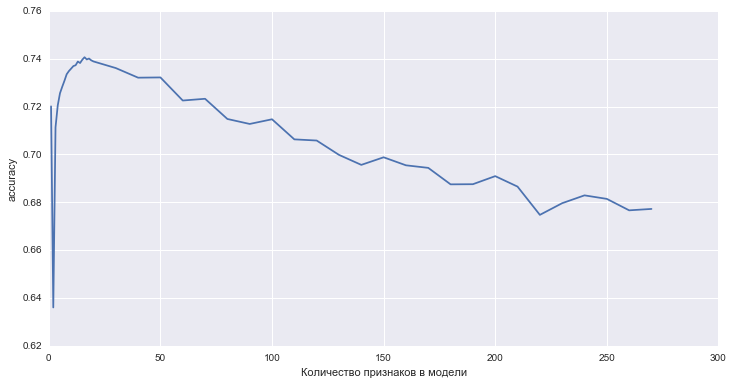

In [211]:
plot(range(1,20,1)+range(20,len(features_final),10), scores_features);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format((range(1,20,1)+range(20,len(features_final),10))[np.argmax(scores_features)]))

Используем более "правильный" алгоритм определения оптимального количества признаков - рекурсивное удаление признаков с кросвалидацией - RFECV

In [18]:
len(features_full)

279

Optimal number of features : 17


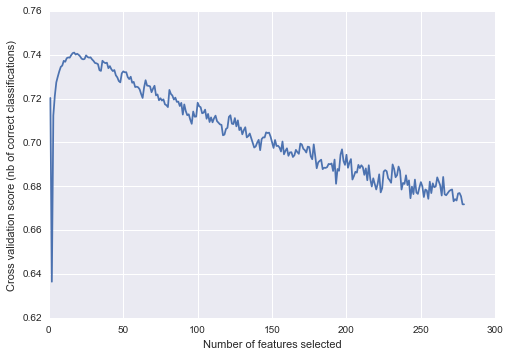

Wall time: 14h 17min 25s


In [19]:
%%time
# https://stackoverflow.com/questions/24123498/recursive-feature-elimination-on-random-forest-using-scikit-learn
#http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
from sklearn.feature_selection import RFECV

n_features=279
rf = RandomForestClassifier(n_estimators=100,max_features='auto',random_state=7)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train[features_full.index[:n_features]], y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Получаем близкий результат по сравнению с простым обходом отранжированных по важности признаков (17 против 16). При этом метод более ресурсозатратен. В дальнейшем используем первый метод отбора оптимального количества признаков.

**GradientBoostingClassifier**

In [166]:
from tqdm import tqdm 
from sklearn.ensemble import GradientBoostingClassifier

scores_features2=[]
for n in tqdm(range(10,len(features_final),10)):
    scores_features_=cross_val_score(GradientBoostingClassifier(max_depth=10,n_estimators=100,
                                     random_state=7,verbose=0),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features2.append(np.mean(scores_features_))


  0%|                                                   | 0/27 [00:00<?, ?it/s]

100%|█████████████████████████████████████| 27/27 [27:42:44<00:00, 5548.01s/it]


max accuracy : 0.747
Количество признаков в модели при max accuracy : 140


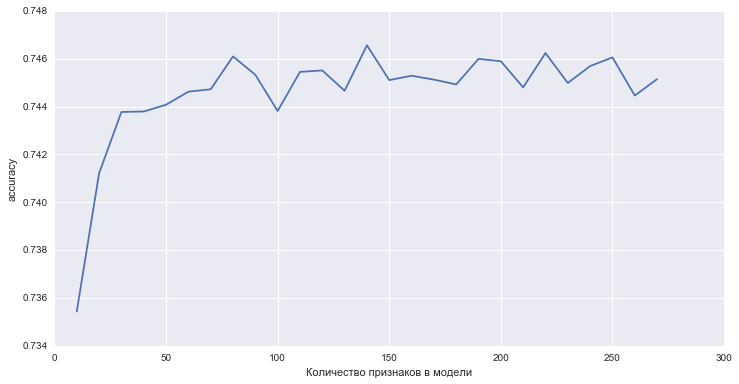

In [190]:
plot(range(10,len(features_final),10), scores_features2);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features2),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format(range(10,len(features_final),10)[np.argmax(scores_features2)]))

**KNeighborsClassifier**

In [202]:
from sklearn.neighbors import KNeighborsClassifier

scores_features3=[]
for n in tqdm(range(1,20,1)+range(20,len(features_final),10)):
    scores_features_=cross_val_score(KNeighborsClassifier(n_neighbors=25,n_jobs=-1),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features3.append(np.mean(scores_features_))

100%|██████████████████████████████████████████| 45/45 [24:31<00:00, 92.36s/it]


max accuracy : 0.732
Количество признаков в модели при max accuracy : 2


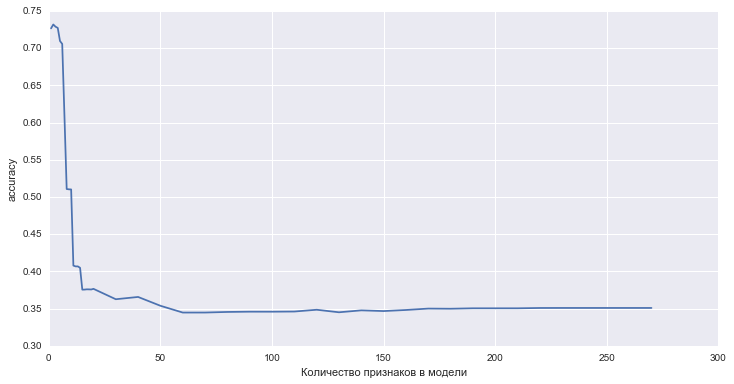

In [203]:
plot(range(1,20,1)+range(20,len(features_final),10), scores_features3);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features3),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format((range(1,20,1)+range(20,len(features_final),10))[np.argmax(scores_features3)]))

**LinearSVC**

In [204]:
from sklearn.svm import LinearSVC

scores_features4=[]
for n in tqdm(range(1,20,1)+range(20,len(features_final),10)):
    scores_features_=cross_val_score(LinearSVC(C=1.0, multi_class='ovr', random_state=7),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features4.append(np.mean(scores_features_))

100%|███████████████████████████████████████| 45/45 [2:17:06<00:00, 364.62s/it]


max accuracy : 0.553
Количество признаков в модели при max accuracy : 6


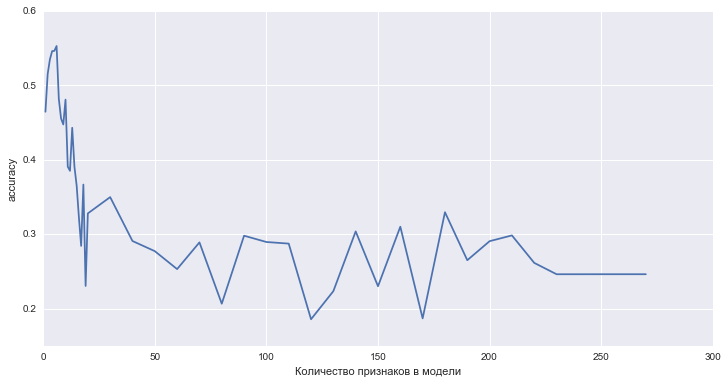

In [205]:
plot(range(1,20,1)+range(20,len(features_final),10), scores_features4);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features4),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format((range(1,20,1)+range(20,len(features_final),10))[np.argmax(scores_features4)]))

**LogisticRegression**

In [212]:
from sklearn.linear_model import LogisticRegression

scores_features5=[]
for n in tqdm(range(1,20,1)+range(20,len(features_final),10)):
    scores_features_=cross_val_score(LogisticRegression(solver='lbfgs', multi_class='multinomial'),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features5.append(np.mean(scores_features_))

100%|██████████████████████████████████████████| 45/45 [09:05<00:00, 17.96s/it]


max accuracy : 0.553
Количество признаков в модели при max accuracy : 5


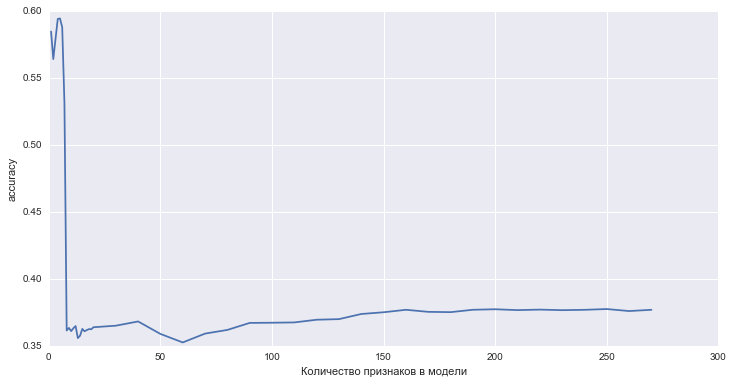

In [213]:
plot(range(1,20,1)+range(20,len(features_final),10), scores_features5);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features5),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format((range(1,20,1)+range(20,len(features_final),10))[np.argmax(scores_features5)]))

**LogisticRegression L2**

In [214]:
from sklearn.linear_model import LogisticRegression

scores_features5=[]
for n in tqdm(range(1,20,1)+range(20,len(features_final),10)):
    scores_features_=cross_val_score(LogisticRegression(penalty='l2'),\
                                     X_train[features_full.index[:n]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features5.append(np.mean(scores_features_))

100%|██████████████████████████████████████| 45/45 [6:56:43<00:00, 1618.22s/it]


max accuracy : 0.553
Количество признаков в модели при max accuracy : 60


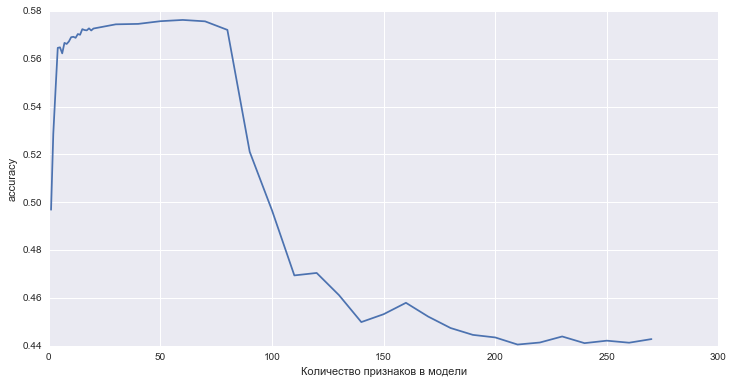

In [215]:
plot(range(1,20,1)+range(20,len(features_final),10), scores_features5);
plt.xlabel("Количество признаков в модели")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features5),3)))
print("Количество признаков в модели при max accuracy : \
{:0.0f}".format((range(1,20,1)+range(20,len(features_final),10))[np.argmax(scores_features5)]))

Для дальнейшего подбора параметров классификаторов отберем  следующие модели:

    RandomForestClassifier - 16 признаков
    GradientBoostingClassifier - 140 признаков
    KNeighborsClassifier - 2 признаков

### Часть 9. Кросс-валидация, подбор параметров

In [26]:
from tqdm import tqdm 
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

**RandomForestClassifier**

In [216]:
scores_features=[]
n_features=16
for depth in tqdm(range(2,25,1)):
    scores_features_=cross_val_score(RandomForestClassifier(max_depth=depth, n_estimators=100,max_features='auto',
                            random_state=7,verbose=1),\
                            X_train[features_full.index[:n_features]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features.append(np.mean(scores_features_))

100%|██████████████████████████████████████████| 23/23 [07:23<00:00, 26.40s/it]


max accuracy : 0.743
Значение параметра max_depth RandomForestClassifier при max accuracy : 14


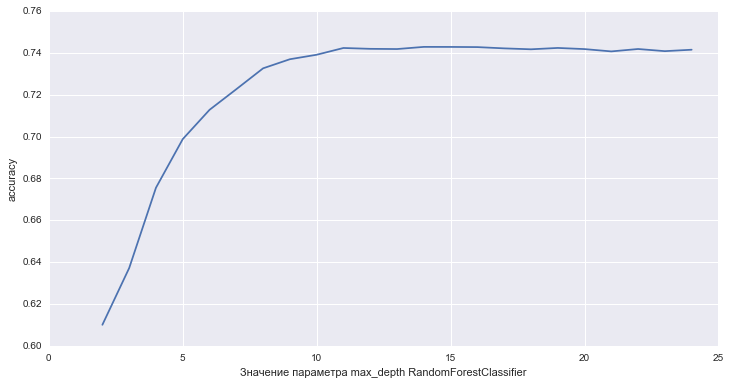

In [222]:
plot(range(2,25,1), scores_features);
plt.xlabel("Значение параметра max_depth RandomForestClassifier")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features),3)))
print("Значение параметра max_depth RandomForestClassifier при max accuracy : \
{:0.0f}".format(range(2,25,1)[np.argmax(scores_features)]))

**GradientBoostingClassifier**

In [223]:
n_features=140
scores_features2=[]
for depth in tqdm(range(2,25,1)):
    scores_features_=cross_val_score(GradientBoostingClassifier(max_depth=depth,n_estimators=100,
                            random_state=7,verbose=0),\
                            X_train[features_full.index[:n_features]], y_train, n_jobs=-1, scoring="accuracy", cv=3)
    
    scores_features2.append(np.mean(scores_features_))

100%|████████████████████████████████████| 23/23 [44:57:21<00:00, 11708.40s/it]


max accuracy : 0.749
Значение параметра max_depth GradientBoostingClassifier при max accuracy : 5


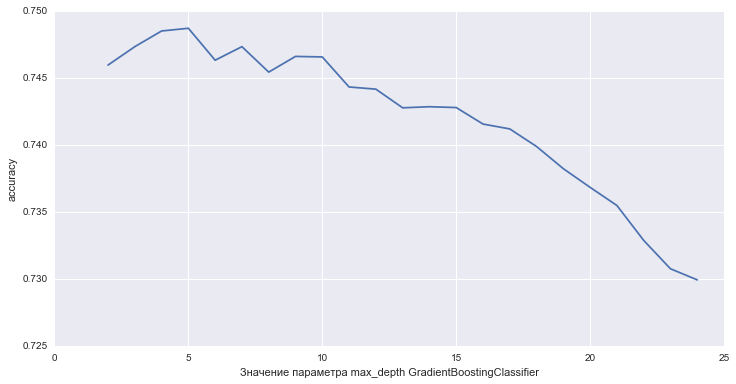

In [226]:
plot(range(2,25,1), scores_features2);
plt.xlabel("Значение параметра max_depth GradientBoostingClassifier")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features2),3)))
print("Значение параметра max_depth GradientBoostingClassifier при max accuracy : \
{:0.0f}".format(range(2,25,1)[np.argmax(scores_features2)]))

GradientBoostingClassifier имеет большое количество настраиваемых параметров. Попробуем более подробно поперебирать параметры, чтобы поискать лучшую модель

In [23]:
%%time
# project_example_banks
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

n_features=140

gbm_params = { 'n_estimators': [100,150,200],
               'learning_rate':(0.1, 0.5, 1),               
               'min_samples_leaf': list(range(10, 31, 5))}

# Проводим кросс-валидацию 
grid = GridSearchCV(GradientBoostingClassifier(max_depth=5), gbm_params, 
                    cv=StratifiedKFold(y_train, n_folds=3, shuffle=False, random_state=7), 
                    n_jobs=-1, scoring="accuracy",verbose=1)

grid.fit(X_train[features_full.index[:n_features]], y_train)
print('GradientBoostingClassifier', grid.best_score_ , "\n", grid.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 277.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 761.8min finished


GradientBoostingClassifier 0.752646464646 
 {u'n_estimators': 100, u'learning_rate': 0.1, u'min_samples_leaf': 30}
Wall time: 12h 51min 25s


**KNeighborsClassifier**

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
n_features=2
X_scaled = scaler.fit_transform(X_train[features_full.index[:n_features]])

In [29]:
%%time
from sklearn.neighbors import KNeighborsClassifier
scores_features3=[]
neighb = np.arange(1,76,1)
for n in neighb:
    scores_features_ = cross_val_score(KNeighborsClassifier(n_neighbors=n),X_scaled, y_train, n_jobs=-1,
                            scoring="accuracy", cv=3)
    
    scores_features3.append(np.mean(scores_features_))

Wall time: 5min 30s


max accuracy : 0.733
Значение параметра max_depth KNeighborsClassifier при max accuracy : 30


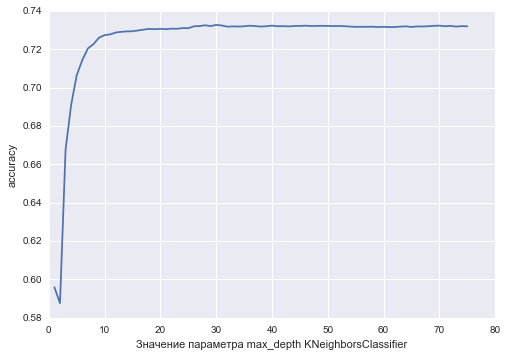

In [33]:
plot(neighb, scores_features3);
plt.xlabel("Значение параметра max_depth KNeighborsClassifier")
plt.ylabel("accuracy")
print("max accuracy : {:0.3f}".format(np.around(max(scores_features3),3)))
print("Значение параметра max_depth KNeighborsClassifier при max accuracy : \
{:0.0f}".format(neighb[np.argmax(scores_features3)]))

RandomForestClassifier, GradientBoostingClassifier, KNeighborsClassifier будем использовать дальше при смешивании классификаторов (blending) и постороении классификатора над другими классификаторами (stacking)

### Часть 10. Кривые валидации и обучения

In [36]:
from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve

In [37]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf, X, y, train_sizes, cv=cv, scoring=scoring)
    
    plt.figure(figsize=(12,6))
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')    
    plt.xlabel('Training Set Size');     
    plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name, cv_param_values, cv=5, scoring=scoring)
    
    plt.figure(figsize=(12,6))
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')   
    plt.xlabel(cv_param_name);     
    plt.ylabel(scoring)
    plt.legend()

Wall time: 2h 58min 18s


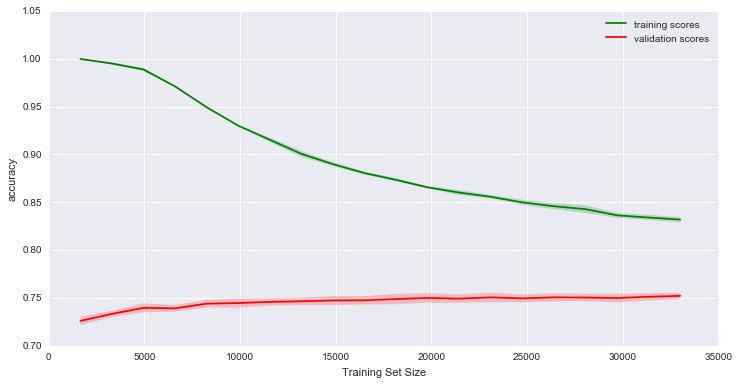

In [38]:
%%time
# Кривая обучения
n_features=140
plot_learning_curve(GradientBoostingClassifier(max_depth=5, n_estimators=100, learning_rate=0.1, min_samples_leaf=30,
                                           max_features='auto',random_state=7),
                   X_train[features_full.index[:n_features]], y_train, scoring='accuracy', cv=3)

Поскольку объем данных ограничен, разумно поварьировать размер имеющейся обучающей выборки и посмотреть, как качество решения задачи зависит от объема данных, на котором мы обучали модель. Так получаются кривые обучения (learning curves). На полученой кривой обучения видно, что оценка обучения находится на максимальном уровне. В текущем датасете нам явно не хватает данных для обучения. Хорошая тенденция, когда кривые постепенно сходятся, и если добавлять в модель данные, можно дальше повышать качество на валидации.

Wall time: 1h 12min 51s


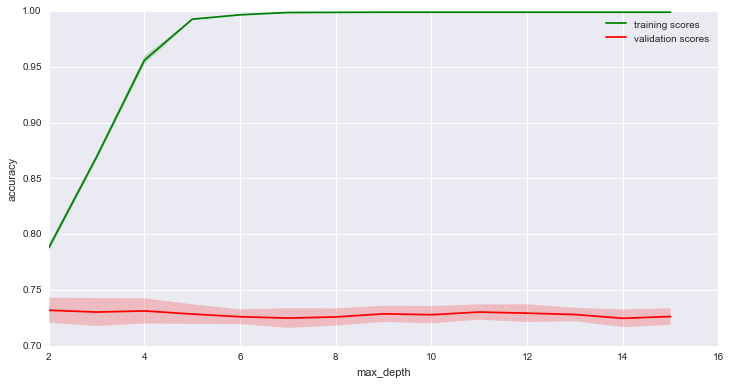

In [55]:
%%time
# Кривая валидации
depth= np.linspace(2, 15, 14)
plot_validation_curve(GradientBoostingClassifier( n_estimators=100, learning_rate=0.1, 
                                                 min_samples_leaf=30, max_features='auto',random_state=7,verbose=0),
                    X_train[features_full.index[:n_features]][:5000], y_train[:5000], 
                    cv_param_name='max_depth', 
                    cv_param_values=depth,
                    scoring='accuracy')

Как видно, при достижении определенной глубины деревьев accuracy  выходит на асимптоту и далее начинает плавно снижаться,таким образом можно понять, какая глубина деревьев оптимальна для задачи

### Часть 11. Прогноз для тестовой (или отложенной) выборки

In [57]:
%%time
# https://github.com/glebmikha/ipython_notebooks/blob/master/default_prediction.ipynb

rf = RandomForestClassifier(max_depth=14, n_estimators=100, max_features='auto', random_state=7)
gbm_params = {'n_estimators': 100, 'learning_rate': 0.1, 'min_samples_leaf': 30}
gb = GradientBoostingClassifier(max_depth=5, **gbm_params)    
knn = KNeighborsClassifier(n_neighbors=30)

models = []
models.append(rf)
models.append(gb)
models.append(knn)

n_features_list=[16,140,2] # оптимальное количество отранжированных признаков

for model, n_features in zip(models,n_features_list):
    model.fit(X_train[features_full.index[:n_features]], y_train)

Wall time: 10min 6s


In [59]:
from sklearn.metrics import accuracy_score
accuracy_scr=[]
for model, n_features in zip(models,n_features_list):
    
        pred_scr = model.predict(X_test[features_full.index[:n_features]])# [:, 1]
        accuracy_ = accuracy_score(np.array(y_test), pred_scr)
        accuracy_scr.append(accuracy_)

RandomForestClassifier  -  0.7402
GradientBoostingClassifier  -  0.74938
KNeighborsClassifier  -  0.72402


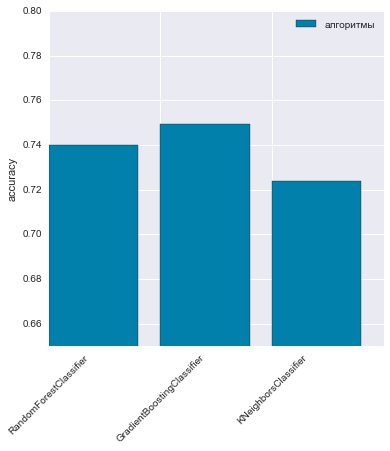

In [74]:
xticks = ['RandomForestClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier']
accuracy = accuracy_scr

for x,a in zip(xticks, accuracy):
    print (x,' - ', a)

plt.figure(figsize=(6, 6))
plt.bar(np.arange(len(accuracy)), accuracy, color='#0080AA', label=u'алгоритмы')
plt.xticks(np.arange(len(accuracy)), xticks, rotation=45)

#plt.xlim([0, 4])
plt.ylim([0.65, 0.80])
plt.ylabel('accuracy')
plt.legend(loc=1);

### Часть 12. Блендинг. Смешивание классификаторов

Попробуем увеличить качество модели путем смешивания нескольких классификаторов. Кросс-валидацию будем проводить чтобы получить в том числе out_of_fold оценки целевой переменной

In [78]:
# lesson5_practice_churn_blending_rf_xgboost_solution
# https://www.kaggle.com/general/18793
def out_of_fold_prediction(clf, train_df, y_series, folds, scale=False):
    
    prediction = y_series.copy()
    for train_idx, test_idx in folds:
        X_train, X_test = train_df.iloc[train_idx, :], train_df.iloc[test_idx,:]
        y_train, y_test = y_series.iloc[train_idx], y_series.iloc[test_idx]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train, y_train)        
        prediction.iloc[test_idx] = clf.predict(X_test)#[:, 1]        
    return(prediction)

Будем смешивать следующие классификаторы RandomForestClassifier, GradientBoostingClassifier и KNeighborsClassifier

In [79]:
%%time
folds = StratifiedKFold(y_train, n_folds=5, random_state=7)
# будем смешивать RandomForestClassifier, GradientBoostingClassifier и KNeighborsClassifier
n_features=16
rf_oof_pred = out_of_fold_prediction(rf, X_train[features_full.index[:n_features]], y_train, folds)
print('CV RandomForestClassifier : {0} '.format(round(accuracy_score(y_train, rf_oof_pred), 4)))

n_features=140
gb_oof_pred = out_of_fold_prediction(gb, X_train[features_full.index[:n_features]], y_train, folds)
print('CV GradientBoostingClassifier: {0} '.format(round(accuracy_score(y_train, gb_oof_pred), 4)))

n_features=2
knn_oof_pred = out_of_fold_prediction(knn, X_train[features_full.index[:n_features]], y_train, folds, scale=True)
print('CV KNeighborsClassifier: {0} '.format(round(accuracy_score(y_train, knn_oof_pred), 4)))

CV RandomForestClassifier : 0.743 
CV GradientBoostingClassifier: 0.7534 
CV KNeighborsClassifier: 0.7322 
Wall time: 38min 22s


Реализуем функцию которая будет перебирать доли каждой модели для поиска оптимальных долей смешивания классификаторов

In [117]:
def best_linear_mix(target, pred1, pred2, pred3, metric=accuracy_score):
    best_metric, best_w1,  best_w2 = 0, 0, 0
    for w1 in np.linspace(0, 1, 50):
          for w2 in np.linspace(0, 1-w1, 5):        
            curr_pred = (w1 * pred1 +  w2 * pred2 + (1 - w1 - w2) * pred3 )
            # accuracy_score требует целочисленных y_true, y_pred -> curr_pred.round()
            curr_metric =  metric(target, curr_pred.round())
            if curr_metric > best_metric:
                best_metric = curr_metric
                best_pred = curr_pred
                best_w1 = w1
                best_w2 = w2
            # print (w1, w2, w1+w2)
                
    return best_metric, best_pred, best_w1, best_w2

In [118]:
%%time
best_acr, best_pred, best_w1, best_w2 = best_linear_mix(y_train, rf_oof_pred, gb_oof_pred, knn_oof_pred)

Wall time: 1.27 s


In [119]:
 print("out_of_fold accuracy_score смешанной модели : {:0.3f}".format(np.around(np.max(best_acr),4)))

out_of_fold accuracy_score смешанной модели : 0.753


In [120]:
round(best_w1, 2),round(best_w2, 2)

(0.0, 1.0)

In [121]:
n_features=140
gb_pred_scr = gb.predict(X_test[features_full.index[:n_features]])

rf_gb_knn =best_w2 * gb_pred_scr  
print(round(accuracy_score(y_test, rf_gb_knn), 4))

0.7488


Смешивание трех классификаторов на тестовой выборке не дает прироста качества модели. Более того модель GradientBoostingClassifier забивает все остальные (её вес при объединении классификаторов равен 1.0)

         _______________________________________
         |  ROC AUC    | Out-of-fold |  Test   |
         |_____________|_____________|_________|
         | RF          |   .743      |  .740   |
         | GB          |   .753      |  .749   |
         | Knn         |   .732      |  .724   |
         | RF+GB+Knn   |   .753      |  .749   |
         |_____________|_____________|_________|

### Часть 13. Стэкинг. Построение классификатора над другими классификаторами

In [122]:
# https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb
# https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/

In [123]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)              

        return self    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

**Базовые алгоритмы и мета алгоритм **

В качестве базовых алгоритмов будем использовать теже алгоритмы которые использовались для блендинга классификаторов - RandomForestClassifier, GradientBoostingClassifier и KNeighborsClassifier, в качестве мета-алгоритма - Ridge классификатор

In [124]:
def score_st(clf, X, y, label):
    a = clf.predict(X)   
    print (label + ' accuracy_score  = ' + str( accuracy_score(y, a.round()) ))

Чтобы не усложнять стэкинг, в каждой модели будем учитывать одинаковое количество отранжированных по важности признаков

In [125]:
# заново перепишем модели
rf = RandomForestClassifier(max_depth=14, n_estimators=100, max_features='auto', random_state=7)
gbm_params = {'n_estimators': 100, 'learning_rate': 0.1, 'min_samples_leaf': 30}
gb = GradientBoostingClassifier(max_depth=5, **gbm_params)    
knn = KNeighborsClassifier(n_neighbors=30)

n_features=50 # одинаковое количество признаков
X_train_st = X_train[features_full.index[:n_features]]
rf.fit(X_train_st, y_train)
gb.fit(X_train_st, y_train)
knn.fit(X_train_st, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [126]:
%%time
from sklearn.linear_model import Ridge
from sklearn.svm import SVC

models = [rf,gb,knn] 
ens_model = Ridge()  #svm.SVC(gamma=.2) #LinearSVC() #Ridge()
X_test_st =  X_test[features_full.index[:n_features]]


s1 = DjStacking(models, ens_model)
s1.fit(X_train_st, y_train)
score_st(s1, X_test_st, y_test, '1-stacking')

s2 = DjStacking(models, ens_model)
s2.fit(X_train_st, y_train, p=-1)
score_st(s2, X_test_st, y_test, '2-stacking')

1-stacking accuracy_score  = 0.70034
2-stacking accuracy_score  = 0.70262
Wall time: 16min 8s


In [134]:
%%time
from sklearn.linear_model import Ridge
from sklearn.svm import SVC

models = [rf,gb,knn] 
ens_model = SVC()  #svm.SVC(gamma=.2) #LinearSVC() #Ridge()
X_test_st =  X_test[features_full.index[:n_features]]


s1 = DjStacking(models, ens_model)
s1.fit(X_train_st, y_train)
score_st(s1, X_test_st, y_test, '1-stacking')

s2 = DjStacking(models, ens_model)
s2.fit(X_train_st, y_train, p=-1)
score_st(s2, X_test_st, y_test, '2-stacking')

1-stacking accuracy_score  = 0.74666
2-stacking accuracy_score  = 0.74702
Wall time: 18min 19s


При использовании стэкинга тренировочная выборка разделяется на две части - для обучения базовых алгоритмов, для обучения мета-алгоритма которому на вход подаются результаты базовых алгоритмов. В результате базовые алгоритмы обучаются на меньшей части выборки, чем если бы не использовался стэкинг. В текущей задаче на кривой обучения видно, что данных для обучения недостаточно и уменьшение данных для обучения базовых классификаторов может не способствовать росту метрики качества. В нашем случае в результате стекинга оценка accuracy не превысила оценку лучшей модели

### Часть 14. Оценка модели с описанием выбранной метрики

Построена модель предсказания определенной возрастной группы абонента. Модель предсказывает с 75-% долей правильных ответах на порядка 50% тестовой выборки. Классы не достаточно равномерно представлены во всей выборке. Тем не менее семплирование миноритарных классов не проводилось. 

Построены кривые обучения и валидации. На полученой кривой обучения видно, что оценка обучения находится на максимальном уровне. В текущем датасете не хватает данных для обучения с получения более высоких значений accuracy_score. Жадным перебором найдена оптимальная  max_depth для GradientBoostingClassifier. По кривой валидации видно, что дальше с ростом max_depth модель начинает слегка переобучаться. 

Для повышения целевой метрики качества использовались подходы смешивания классификаторов (блендинг) и построения классификатора над другими классификаторами (стэкинг). В силу доминирования одной модели данные подходы не увеличили оценку относительно лучшей модели - GradientBoostingClassifier

### Часть 15. Выводы

Построенная модель основана на классификаторе GradientBoostingClassifier использует 140 отранжированных в порядке значимости признаков показывает точность - 75-%  правильных ответов.

Более интерпритируемая модель KNeighborsClassifier при использовании только 2 наиболее важных признаков показывает точность - 72.4-%  правильных ответов.

Поскольку данные анонимизированны нет возможности комментировать эти признаки.

Модель прогнозирования определенной возрастной группы абонента очень важна для мобильных операторов, которые постоянно работают над улучшением тарифных планов и предлагают своим клиентам новые услуги. Каждое предложение должно быть адресовано определенной возрастной группе.